# Building a collaborative Multi-Agent System in LangGraph

#🧩 Project Objective / Problem Statement

The objective of this project is to design and implement a collaborative Multi-Agent System using LangGraph that functions as an intelligent Data Analyst Assistant.

Traditional single-agent systems are often limited in their ability to handle multiple tools or cross-domain tasks effectively — even when powered by advanced models like GPT-4o.
To overcome this limitation, this project adopts a divide-and-conquer (multi-agent) strategy, where specialized agents are designed for different subtasks and coordinate through a central router.

The system will consist of:

🔹 Researcher Agent – Responsible for fetching and analyzing live information using web search and retrieval tools.

🔹 Chart Generator Agent – Expert in visualizing data, generating insights through Python-based charts and graphs.

🔹 Conditional Routing adges  – Directs user queries to the correct specialized agent based on context and intent.

This approach aims to enhance task accuracy, scalability, and efficiency by allowing agents to collaborate intelligently — forming the foundation for next-generation Agentic AI Data Analysis systems.

In [1]:
!pip install langchain
!pip install langchain_openai
!pip install langchain_community
!pip install langgraph
!pip install langchain-experimental
!pip install langchain-tavily


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.6/449.6 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.77
    Uninstalling langchain-core-0.3.77:
      Successfully uninstalled langchain-core-0.3.77
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is

In [2]:
from getpass import getpass
OPENAI_API_KEY=getpass("enter openai key:-")
TAVILY_API_KEY=getpass("enter TAVILY_API_KEY:-")


enter openai key:-··········
enter TAVILY_API_KEY:-··········


In [3]:
import os
os.environ["OPENAI_API_KEY"]=OPENAI_API_KEY
os.environ["TAVILY_API_KEY"]=TAVILY_API_KEY

In [4]:
from langchain_openai import ChatOpenAI
llm=ChatOpenAI(model="gpt-4o",temperature=0)

__Tools Creation__

In [5]:
from langchain_tavily import TavilySearch
tv_search=TavilySearch(max_results=4,search_depth='advanced',
                                max_tokens=10000) #becuse it's already made as a tool bcoz is runnable , we can directly use it in our agent.
web_search_tool=tv_search.name

In [6]:
from langchain.tools import tool
from langchain_experimental.utilities import PythonREPL
from langchain_core.messages import ToolMessage
from typing import Annotated
python_compiler=PythonREPL()


@tool
def python_code_execution(code:Annotated[str,"it's a python code which will be execute by this tool."]):
  "A tool for excecute the python code and generate the output from it."
  try:
    result=python_compiler.run(code)
  except BaseException as e:
    return f"failed to execute. Error: {repr(e)}"
  return f"output of the code :- {result}, if you completed all task then responed with Final Answer."





In [ ]:
python_code_execution("x=1/0")

/tmp/ipython-input-3979079114.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  python_code_execution("x=1/0")


"output of the code :- ZeroDivisionError('division by zero'), if you completed all task then responed with Final Answer."

__2 sample agent(specific){llm+tools} creation__

__Note:-__
1) there is most important role of prompt. in prompt we need to tell our agent that another agent also working so u can generate response as much u can , for remaining work can be done by other agent .

2) telling the condition by which this agents calling can stop and final delivery happens to user.

3) mention any limitation of agent and also mention the responsibility.

In [7]:
#Web search agent
from langchain_core.prompts import ChatPromptTemplate , MessagesPlaceholder
prompt_temp=ChatPromptTemplate.from_messages([
    ('system',f"""You are a helpful AI assistant, collaborating with other assistants.
                          Use the provided tools to progress towards answering the question.
                          If you are unable to fully answer, that's OK,
                          another assistant with different tools will help where you left off.
                          Execute what you can to make progress.
                          If you or any of the other assistants have the final answer or deliverable,
                          prefix your response with FINAL ANSWER so the team knows to stop.

                          You have access to the following tools:
                          {web_search_tool}

                          You should provide accurate data for use
                          and source code shouldn't be the final answer  """),
  MessagesPlaceholder(variable_name='messages')
])
#prompt = situation + limitation + responsibility + tools description + capability

In [8]:
web_search_chain=prompt_temp | llm.bind_tools([tv_search])

In [ ]:
web_search_chain.invoke({'messages':[('user',"give me demo python code. and excute it like data visulization.")]})

AIMessage(content='I can provide you with a demo Python code for data visualization using libraries like Matplotlib and Seaborn. However, I can\'t execute the code directly here. You can run the code in your local environment or an online Python compiler that supports these libraries.\n\nHere\'s a simple example of data visualization using Matplotlib and Seaborn:\n\n```python\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport pandas as pd\n\n# Sample data\ndata = {\n    \'Category\': [\'A\', \'B\', \'C\', \'D\'],\n    \'Values\': [23, 45, 56, 78]\n}\n\n# Create a DataFrame\ndf = pd.DataFrame(data)\n\n# Set the style of seaborn\nsns.set_style("whitegrid")\n\n# Create a bar plot\nplt.figure(figsize=(8, 6))\nsns.barplot(x=\'Category\', y=\'Values\', data=df, palette=\'viridis\')\n\n# Add title and labels\nplt.title(\'Sample Bar Plot\')\nplt.xlabel(\'Category\')\nplt.ylabel(\'Values\')\n\n# Show the plot\nplt.show()\n```\n\n### Instructions to Run the Code:\n1. **Install the R

In [9]:
#chat creation agent.
prompt_temp2=ChatPromptTemplate.from_messages([
    ('system',f"""
   You are a helpful AI assistant, collaborating with other assistants.
                          Use the provided tools to progress towards answering the question.
                          If you are unable to fully answer, that's OK,
                          another assistant with different tools will help where you left off.
                          Execute what you can to make progress.
                          If you or any of the other assistants have the final answer or deliverable,
                          prefix your response with FINAL ANSWER so the team knows to stop.

                          You have access to the following tools:
                          {python_code_execution.name}

                          Run the python code to display the chart    """),
    MessagesPlaceholder(variable_name='messages')
])
code_expert_chain=prompt_temp2 | llm.bind_tools([python_code_execution])

In [ ]:
code_expert_chain.invoke({'messages':[('user',"""I can provide you with a demo Python code for data visualization using libraries like Matplotlib and Seaborn. However, I can\'t execute the code directly here. You can run the code in your local environment or an online Python compiler that supports these libraries.\n\nHere\'s a simple example of data visualization using Matplotlib and Seaborn:\n\n```python\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport pandas as pd\n\n# Sample data\ndata = {\n    \'Category\': [\'A\', \'B\', \'C\', \'D\'],\n    \'Values\': [23, 45, 56, 78]\n}\n\n# Create a DataFrame\ndf = pd.DataFrame(data)\n\n# Set the style of seaborn\nsns.set_style("whitegrid")\n\n# Create a bar plot\nplt.figure(figsize=(8, 6))\nsns.barplot(x=\'Category\', y=\'Values\', data=df, palette=\'viridis\')\n\n# Add title and labels\nplt.title(\'Sample Bar Plot\')\nplt.xlabel(\'Category\')\nplt.ylabel(\'Values\')\n\n# Show the plot\nplt.show()\n```\n\n### Instructions to Run the Code:\n1. **Install the Required Libraries**: Make sure you have Matplotlib, Seaborn, and Pandas installed. You can install them using pip:\n   ```bash\n   pip install matplotlib seaborn pandas\n   ```\n\n2. **Run the Code**: Copy the code into a Python file (e.g., `visualization_demo.py`) and execute it```\n\nThis code will generate a simple bar plot visualizing the sample data provided. You can modify the data and customize the plot as needed.""")]})

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AZuMy5APDDxxKzSMeg4nkRP3', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\nimport seaborn as sns\\nimport pandas as pd\\n\\n# Sample data\\ndata = {\\n    \'Category\': [\'A\', \'B\', \'C\', \'D\'],\\n    \'Values\': [23, 45, 56, 78]\\n}\\n\\n# Create a DataFrame\\ndf = pd.DataFrame(data)\\n\\n# Set the style of seaborn\\nsns.set_style(\\"whitegrid\\")\\n\\n# Create a bar plot\\nplt.figure(figsize=(8, 6))\\nsns.barplot(x=\'Category\', y=\'Values\', data=df, palette=\'viridis\')\\n\\n# Add title and labels\\nplt.title(\'Sample Bar Plot\')\\nplt.xlabel(\'Category\')\\nplt.ylabel(\'Values\')\\n\\n# Show the plot\\nplt.show()"}', 'name': 'python_code_execution'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 189, 'prompt_tokens': 514, 'total_tokens': 703, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_toke

__Creation of agent__

In [15]:
from langchain_core.messages import ToolMessage,AIMessage
def research_agent(state):
  result=web_search_chain.invoke(state['messages'])
  if isinstance(result,ToolMessage):
    pass
  else:
    result=AIMessage(**result.model_dump(exclude={'type','name'}),name='research_agent') #serielize the model into dictionary

  return {
      'messages':[result],
      'sender':'research_agent'
  }

def code_execution_agent(state):
  result=code_expert_chain.invoke(state['messages'])
  if isinstance(result,ToolMessage):
    pass
  else:
    result=AIMessage(**result.model_dump(exclude={'type','name'}),name='code_execution_agent')
  return {
      'messages':[result],
      'sender':'code_execution_agent'
  }


In [ ]:
code_execution_agent({'messages':[('user',"""I can provide you with a demo Python code for data visualization using libraries like Matplotlib and Seaborn. However, I can\'t execute the code directly here. You can run the code in your local environment or an online Python compiler that supports these libraries.\n\nHere\'s a simple example of data visualization using Matplotlib and Seaborn:\n\n```python\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport pandas as pd\n\n# Sample data\ndata = {\n    \'Category\': [\'A\', \'B\', \'C\', \'D\'],\n    \'Values\': [23, 45, 56, 78]\n}\n\n# Create a DataFrame\ndf = pd.DataFrame(data)\n\n# Set the style of seaborn\nsns.set_style("whitegrid")\n\n# Create a bar plot\nplt.figure(figsize=(8, 6))\nsns.barplot(x=\'Category\', y=\'Values\', data=df, palette=\'viridis\')\n\n# Add title and labels\nplt.title(\'Sample Bar Plot\')\nplt.xlabel(\'Category\')\nplt.ylabel(\'Values\')\n\n# Show the plot\nplt.show()\n```\n\n### Instructions to Run the Code:\n1. **Install the Required Libraries**: Make sure you have Matplotlib, Seaborn, and Pandas installed. You can install them using pip:\n   ```bash\n   pip install matplotlib seaborn pandas\n   ```\n\n2. **Run the Code**: Copy the code into a Python file (e.g., `visualization_demo.py`) and execute it```\n\nThis code will generate a simple bar plot visualizing the sample data provided. You can modify the data and customize the plot as needed.""")]})

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_izuIM3TGgvFaX6JcgWrgbumb', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\nimport seaborn as sns\\nimport pandas as pd\\n\\n# Sample data\\ndata = {\\n    \'Category\': [\'A\', \'B\', \'C\', \'D\'],\\n    \'Values\': [23, 45, 56, 78]\\n}\\n\\n# Create a DataFrame\\ndf = pd.DataFrame(data)\\n\\n# Set the style of seaborn\\nsns.set_style(\\"whitegrid\\")\\n\\n# Create a bar plot\\nplt.figure(figsize=(8, 6))\\nsns.barplot(x=\'Category\', y=\'Values\', data=df, palette=\'viridis\')\\n\\n# Add title and labels\\nplt.title(\'Sample Bar Plot\')\\nplt.xlabel(\'Category\')\\nplt.ylabel(\'Values\')\\n\\n# Show the plot\\nplt.show()"}', 'name': 'python_code_execution'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 189, 'prompt_tokens': 514, 'total_tokens': 703, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_toke

__Routing edge function__

this function is responsible to correctly play the role of conditional edge logic where it will decide which node will be next after the execution of specific agent node.

In [29]:
from typing import Literal
def conditional_logic(state)->Literal['TOOL_CALL','NEXT_AGENT','END']:
  current_state=state["messages"][-1]
  if current_state.tool_calls : #because currentstate willbe object so we used `.`
    return 'TOOL_CALL'
  if 'FINAL ANSWER' in current_state.content: #we are checking substring so using `in`.
    return 'END'
  else:
    return 'NEXT_AGENT'



__Let's create the Graph__

In [30]:
import operator
from langgraph.graph import StateGraph,END
from langgraph.prebuilt import ToolNode
from typing import TypedDict,Sequence,Annotated
from langchain_core.messages import BaseMessage

class GraphState(TypedDict):
  messages:Annotated[Sequence[BaseMessage],operator.add]
  sender:str

blue_print=StateGraph(GraphState)


In [31]:
tools_node=ToolNode([tv_search,python_code_execution])

In [32]:
blue_print.add_node(research_agent)
blue_print.add_node(code_execution_agent)
blue_print.add_node("tools_node",tools_node)

In [33]:
blue_print.set_entry_point("research_agent")

In [34]:
blue_print.add_conditional_edges("research_agent",conditional_logic,{'TOOL_CALL':"tools_node",'NEXT_AGENT':"code_execution_agent",'END':END})
blue_print.add_conditional_edges("code_execution_agent",conditional_logic,{'TOOL_CALL':"tools_node",'NEXT_AGENT':"research_agent",'END':END})
blue_print.add_conditional_edges("tools_node",lambda x:x['sender'],{'code_execution_agent':"code_execution_agent",'research_agent':'research_agent'})

In [35]:
chatbot=blue_print.compile()

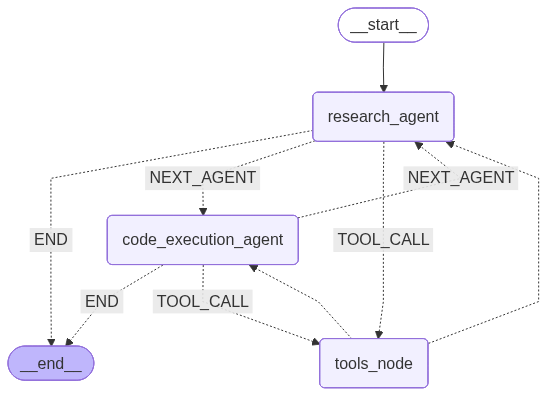

In [27]:
from IPython.display import Image,display

display(Image(chatbot.get_graph().draw_mermaid_png()))

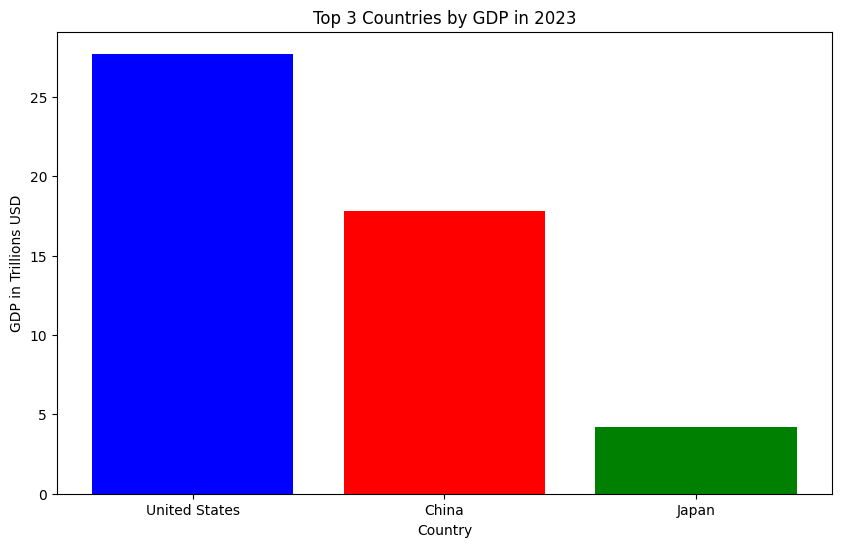

In [37]:
prompt = """Fetch the data of the top 3 countries with the highest GDP in the world.
            Then use this data and draw a bar chart.
         """

response = chatbot.invoke({"messages": [('human', prompt)]},
                        # Maximum number of steps to take in the graph
                        {"recursion_limit": 50},)

In [38]:
response

{'messages': [('human',
   'Fetch the data of the top 3 countries with the highest GDP in the world.\n            Then use this data and draw a bar chart.\n         '),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Ua4rBMUUPbxdoFITlARpQwV3', 'function': {'arguments': '{"query":"top 3 countries by GDP 2023","search_depth":"basic"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 1420, 'total_tokens': 1449, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-COPHDyZSHJwS2VbGxMbQXhGsRhQGw', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='research_agent', id='run--755e0467-6a6c-4c3f-8492-29418d710

In [39]:
type(response)

dict

In [40]:
response['messages'][-1].content

'FINAL ANSWER: The bar chart displaying the GDP of the top 3 countries in 2023 has been successfully created using Matplotlib. The chart shows the United States, China, and Japan with GDP values of $27.72 trillion, $17.795 trillion, and $4.204 trillion, respectively.'

In [41]:
response['sender']

'code_execution_agent'

__WE can see the final answer generated by Code Executor agent.__